In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -U geometric-smote

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample 

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn as nn
from torch_geometric.nn import *


warnings.filterwarnings('ignore')

In [ ]:
class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 165
    output_dim = 1
    hidden_size = 128
    num_layers = 3
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("Using device:", Config.device)

Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DATA LOADING/PREPARATION
df_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [ ]:
print(df_features.shape)
df_features.head()
#df_features[df_features[0].isna()].head()

(203769, 167)


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [ ]:
df_edges.head()
#df_edges[df_edges['txId2'].isna()].head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [ ]:
# Hay dos problemas: 
# - Está desbalanceado y hay que oversamplear la clase 1 para que iguale las muestras de la clase 0.
# - La clase 2 es desconocida por lo que solo aporta ruido. Hay que eliminar todo rastro de esa clase antes de oversampling
print(df_classes['class'].value_counts())
#df_classes[df_classes['txId'].isna()].head()

2    157205
0     42019
1      4545
Name: class, dtype: int64


In [ ]:
# PASO 1: Eliminar todo rastro de la clase desconocida '2' para evitar ruido y poder oversamplear
# 1.1 Quitamos los nodos con clase 2 del df_classes (fácil)
# Quitamos los nodos de la clase desconocida
df_classes2 = df_classes[df_classes['class'] != 2 ] 
print(df_classes2.shape)
print(df_classes2['class'].value_counts())



(46564, 2)
0    42019
1     4545
Name: class, dtype: int64


In [ ]:
# 1.2 Quitamos los nodos con clase 2 del df_features (fácil). Hacemos join con df_classes para saber la clase y suprimirla
print("df_features antes: ", df_features.shape)
df_features2 = pd.merge(df_features,df_classes2,how='inner', left_on=[0], right_on=['txId']).drop(['txId'], axis=1)
print("df_features despues: ", df_features2.shape)
df_features2.head()

df_features antes:  (203769, 167)
df_features despues:  (46564, 168)


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


In [ ]:
# 1.3 Quitamos todas las aristas que tengan algo que ver con la clase 2 (menos fácil). Lo hacemos mediante 2 outer joins (uno contra los nodos origen y otro contra los nodos destino) de la clase desconocida 
# Quitamos los edges donde están involucrados nodos de la clase desconocida
print("df_edges antes: ", df_edges.shape)
df_classes_unknown = df_classes.loc[df_classes['class'] == 2, 'txId']
print("Número de nodos pertenecientes a la clase desconocida: ", df_classes_unknown.shape)
df_edges2 = pd.merge(df_classes_unknown, df_edges, indicator=True, how = 'outer', left_on=['txId'], right_on=['txId1']).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges sin clase 2 en los nodos origen: ", df_edges2.shape)
df_edges2 = pd.merge(df_classes_unknown, df_edges2, indicator=True, how = 'outer', left_on=['txId'], right_on=['txId2']).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges sin clase 2 en los nodos origen ni destino: ", df_edges2.shape)
df_edges2.head()
df_edges2 = df_edges2.astype(int)
# Vemos que una vez se ha eliminado todo rastro de la clase 2, nos encontramos con que hay menos aristas que nodos de las clase 1 y 2 juntas: 36624 vs 46564

df_edges antes:  (234355, 2)
Número de nodos pertenecientes a la clase desconocida:  (157205,)
df_edges sin clase 2 en los nodos origen:  (53198, 2)
df_edges sin clase 2 en los nodos origen ni destino:  (36624, 2)


In [ ]:
# PASO 2: Una vez se ha "limpiado" la clase 2, es necesario fusionar los dfs para tener una única tabla que será la entrada del SMUTE (oversampler)
# 2.1 Añadimos al df_features la columna de clase (fácil). Debería resultar en un mismo número de filas (df_features2)

# 2.2 Añadimos la columna 'destino' al df_features (alias txId2). 
# El resultado será un aumento en el número de filas ya que un nodo puede ser origen de varias aristas.
# Convertimos los NaN a 0 para no tener problemas. Los NaN solo aparecerán en la columna 'destino' porque hay nodos que no son origen de ninguna arista
df_join = pd.merge(df_features2, df_edges2, how = 'left', left_on=[0], right_on=['txId1']).drop('txId1', axis=1).drop_duplicates()
df_join['txId2'].fillna(0, inplace=True)
print("El df resultado tiene la siguiente forma: ", df_join.shape)
print("La distribución de clase en formato tabular seria:\n",df_join['class'].value_counts())
df_join.head()

El df resultado tiene la siguiente forma:  (56045, 169)
La distribución de clase en formato tabular seria:
 0    51362
1     4683
Name: class, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,class,txId2
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0,92491280.0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0,5119722.0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,27553029.0
3,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,234419685.0
4,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,230411688.0


In [ ]:
# PASO 3. Una vez tenemos los datos en forma tabular, los dividimos para la entrada en el oversampler:
X = df_join.rename(columns={'txId2':len(df_join.columns)-2}).drop('class', axis=1)
y = df_join['class']
print("La entrada X tendría la siguiente forma: ", X.shape)
print("La entrada y tendría la siguiente forma: ", y.shape)
print("Distribución de y:\n", y.value_counts())
X.head()

La entrada X tendría la siguiente forma:  (56045, 168)
La entrada y tendría la siguiente forma:  (56045,)
Distribución de y:
 0    51362
1     4683
Name: class, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,92491280.0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,5119722.0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,27553029.0
3,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,234419685.0
4,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230411688.0


In [ ]:
# PASO 4. Realizamos el OVERSAMPLING.
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pandas as pd
from sklearn.impute import SimpleImputer
# Aumentamos la clase menor con G-SMOTE
from gsmote import GeometricSMOTE

ss_over = 0.99
ss_under = 0.5

# Definir la estrategia de sobremuestreo y submuestreo
over = SMOTE(sampling_strategy=ss_over)
#over = GeometricSMOTE(k_neighbors=2, selection_strategy='combined', random_state=5)
under = RandomUnderSampler(sampling_strategy=ss_under)

# Combinar ambas estrategias en un pipeline , ('o', over), ('u', under)
steps = [ ('u', under), ('o', over)]  
pipeline = Pipeline(steps=steps)

X_res, y_res = pipeline.fit_resample(X, y)

print("Resultado oversampling tabular:\n", y_res.value_counts())


Resultado oversampling tabular:
 0    9366
1    9272
Name: class, dtype: int64


In [ ]:
# PASO 5. VOLVER AL FORMATO GRAFO
# 5.1 JUNTAMOS dfs para incluir el campo class
print(X_res.shape)
X_res['class'] = y_res
X_res[167] = X_res[167].astype(int)
X_res = X_res.drop_duplicates(subset=[0, 'class'], keep=False)
print(X_res.shape)
X_res.head()

(18638, 168)
(16277, 169)


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,class
1,98961172,21,-0.155164,0.118609,1.573595,0.253218,0.412676,0.306309,-0.061584,-0.163581,...,0.301910,0.288893,-0.098889,0.835284,0.500052,0.157471,-0.264710,-0.163616,99636464,0
2,191585862,8,-0.130941,-0.193189,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.120631,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,191704191,0
3,312877705,2,-0.171931,-0.156197,1.018602,0.178180,-0.043875,0.222447,-0.061584,-0.163631,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,0
4,71773399,42,-0.168562,0.221727,-0.091383,0.028105,-0.043875,0.054722,-0.061584,-0.163368,...,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,73109960,0
5,22837817,4,-0.140700,-0.049405,1.018602,0.403293,-0.043875,0.390171,0.242712,-0.163632,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0,0


In [ ]:
# 5.2 Reconstruimos df de classes
# 1. Montamos df de classes cogiendo tanto la columna "origen" (txId1 alias 0) como la columna "destino" (txId2 alias 167). Eliminamos todas las apariciones de los nodos con más
df_c_1 = X_res[[0]].drop_duplicates().rename(columns={0:'txId'}).sort_values('txId').reset_index(drop=True)
df_c_2 = X_res[[167]].drop_duplicates().rename(columns={167:'txId'}).sort_values('txId').reset_index(drop=True)
df_nu = pd.concat([df_c_1, df_c_2]).drop_duplicates(subset=['txId'], keep='first')
#print("Nodos unicos: ", df_nu.shape)

# 2. Obtenemos las clases de los nodos unicos
df_classes_smute = pd.merge(df_nu, X_res[[0, 'class']], how = 'inner', left_on=['txId'], right_on=[0]).drop([0], axis=1).drop_duplicates(subset=['txId'], keep='first').dropna(how='any').reset_index(drop=True)
print("df_classes_smute: ", df_classes_smute.shape)
print("Distribución df_classes_smute:\n", df_classes_smute['class'].value_counts())

# 3. Obtener el complementario df_classes_smute para mas adelante. Todos los nodos creados pero que o bien tienen varias clases o bien no tienen porque son solo destinos
# pd.merge(df_classes_unknown, df_edges, indicator=True, how = 'outer', left_on=['txId'], right_on=['txId1']).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
df_classes_smute_c = pd.merge(df_classes_smute['txId'], df_nu, indicator=True, how='outer', left_on=['txId'], right_on=['txId']).query('_merge=="right_only"'). drop(['_merge'], axis=1).reset_index(drop=True).drop_duplicates(subset=['txId'], keep='first')
print("Complementario df_classes_smute (solo nodos): ", df_classes_smute_c.shape)
# quitamos el nodo destino 0 que es "la nada"


df_classes_smute_c.head()



df_classes_smute:  (16276, 2)
Distribución df_classes_smute:
 0    8328
1    7948
Name: class, dtype: int64
Complementario df_classes_smute (solo nodos):  (4726, 1)


,txId
0,0
1,3181
2,6418
3,8936
4,9466


In [ ]:
# 5.3 Reconstruimos df de features
df_features_smute = pd.merge(df_classes_smute['txId'], X_res.drop([167, 'class'], axis=1), how = 'inner', left_on=['txId'], right_on=[0]).drop(['txId'], axis=1).drop_duplicates(subset=[0], keep='first').reset_index(drop=True)
print("df_features_smute: ", df_features_smute.shape)
#df_features_smute.head()

# Eliminamos del df_classes_smute aquellos nodos que no tengan features:
#df_classes_smute = pd.merge(df_classes_smute, df_features_smute[0], how='inner', left_on=['txId'], right_on=[0]).drop([0], axis=1).reset_index(drop=True)
print("df_classes_smute: ", df_classes_smute.shape)
#df_features_smute.head()


df_features_smute:  (16276, 167)
df_classes_smute:  (16276, 2)


In [ ]:
# 5.4 Reconstruimos df de edges

# VOY POR AQUIII

df_edges_smute1 = pd.merge(df_classes_smute_c, X_res[[0, 167]], indicator=True, how = 'outer', left_on=['txId'], right_on=[0]).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges_smute eliminando procesando origenes : ", df_edges_smute1.shape)
df_edges_smute2 = pd.merge(df_classes_smute_c, df_edges_smute1, indicator=True, how = 'outer', left_on=['txId'], right_on=[167]).query('_merge=="right_only"').drop(['txId', '_merge'], axis=1)
print("df_edges_smute procesando origen y destino", df_edges_smute2.shape)
df_edges_smute2 = df_edges_smute2.rename(columns={0:'txId1', 167: 'txId2'}).astype(int).reset_index(drop=True)
df_edges_smute2.head()


# Montamos el df de edges
# , cogiendo solo los nodos de los datos sinteticos que tenian una unica clase
#df_e_1 = pd.merge(df_c['txId'], X_res, how = 'left', left_on=['txId'], right_on=[0]).drop([0], axis=1)

# renombramos e imprimimos
#df_e = df_e_1[['txId', 167]].rename(columns={'txId':'txId1', 167:'txId2'})
#df_e = df_e.sort_values('txId1').reset_index(drop=True)
#print(df_e.shape)
#df_e.head()


df_edges_smute eliminando procesando origenes :  (16277, 2)
df_edges_smute procesando origen y destino (2019, 2)


,txId1,txId2
0,6080579,383013524
1,149698578,149698582
2,54769378,69351072
3,299066207,300144606
4,299044844,300144606


In [ ]:
# ELIMINAR ESTO:Montamos df de features
# , cogiendo solo los nodos de los datos sinteticos que tenian una unica clase
#df_f_1 = pd.merge(df_c['txId'], X_res, how = 'inner', left_on=['txId'], right_on=[0]).drop([0], axis=1)
#df_f_2 = pd.merge(df_c['txId'], X_res, how = 'left', left_on=['txId'], right_on=[167]).drop([0], axis=1)
#df_f_3 = pd.concat([df_f_1, df_f_2]).drop_duplicates().dropna(how='any')

#df_f = df_f_3.drop([167, 'class'], axis=1).rename(columns={'txId':0}).drop_duplicates().sort_values(0).reset_index(drop=True)

#print(df_f.shape)
#df_f.head()

#HASTA UNA DUDA: SALEN MÁS ELEMENOS EN df_f que en df_c y no puede ser. No entiendo porqué. Hacer un outer join para ver porqué .query('_merge=="right_only"')
#df_prueba = pd.merge(df_c, df_f, indicator=True, how = 'outer', left_on=['txId'], right_on=[0]).drop_duplicates()
#print(df_prueba['_merge'].value_counts())
#df_prueba.head()

In [ ]:
# merging node features DF with classes DF
df_merge = df_features_smute.merge(df_classes_smute, how='inner', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

# extracting classified/non-classified nodes
classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# extracting classified/non-classified edges
classified_edges = df_edges_smute2.loc[df_edges_smute2['txId1'].isin(classified[0]) & df_edges_smute2['txId2'].isin(classified[0])]
unclassifed_edges = df_edges_smute2.loc[df_edges_smute2['txId1'].isin(unclassified[0]) | df_edges_smute2['txId2'].isin(unclassified[0])]

In [ ]:
df_merge = df_merge.dropna()
df_merge = df_merge.reset_index(drop = True)
print(df_merge.shape)
df_merge.head()

(16276, 169)


,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
1,9351,48,-0.172970,-0.114281,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163630,...,1.461330,1.461369,-0.098889,0.662264,1.728088,1.539269,1.519700,1.521399,9351,0
2,13646,48,-0.105837,7.566933,2.128587,7.381781,0.134776,7.853911,0.242712,-0.163636,...,-0.321564,-0.092833,-0.098889,1.008304,0.998005,0.372369,0.725860,0.607847,13646,0
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,68869,0
4,134715,11,-0.172504,0.228077,1.573595,0.478330,9.861288,0.557896,-0.061584,-0.163635,...,0.084518,0.088931,-0.098889,9.486290,1.344509,-0.089327,-0.234871,-0.017780,134715,0


In [ ]:
#PREPARING EDGES
# mapping nodes to indices
nodes = df_features_smute[0].values
map_id = {j:i for i,j in enumerate(nodes)}


# mapping edges to indices
edges = df_edges_smute2.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.dropna()
edges = edges.astype(int)


edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()


# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)


Total amount of edges in DAG: torch.Size([2, 2019])


In [ ]:
#PREPARING NODES
# maping node ids to corresponding indexes
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)


classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0) 

labels = node_features['class'].values

# drop indeces, class and temporal axes 
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)


In [ ]:
#PyG DATASET
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features, 
                        edge_index = edge_index, 
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32)) 

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 16276
Number of node features: 165
Number of edges: 2019
Number of edge features: 165
Average node degree: 0.12
Number of classes: 2
Has isolated nodes: True
Has self loops: True
Is directed: True


In [ ]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx], 
                     y_train, 
                     classified_idx, 
                     test_size=0.15, 
                     random_state=Config.seed, 
                     stratify=y_train)
                     
elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 13834
Validation dataset size: 2442
Test dataset size: 0


In [ ]:
#TRAIN/TEST HELPERS
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            #print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
            #      f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
            #      f'Val Acc: {val_acc*100:.2f}%')
        
            if val_loss < best_loss:
                best_loss = val_loss
                #print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index) 
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [ ]:
def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [ ]:
# Pruebas: General Model Class Implementation
import torch_geometric.nn.conv as conv
import inspect
class GNNGeneralModel(torch.nn.Module):
    
    def __init__(self, dim_in, dim_h, dim_out, model, num_layers=2):
        super(GNNGeneralModel, self).__init__()

        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(model(in_channels=dim_in, out_channels=dim_h))

        if self.num_layers > 2:
          for i in range(1,self.num_layers-1,1):
              layer = model(in_channels=dim_h, out_channels=dim_h) 
              self.layers.append(layer)

        layer = model(in_channels=dim_h, out_channels=dim_out)
        self.layers.append(layer)

    def forward(self, x, edge_index):

        for i in range(0,self.num_layers-1,1):
          h = self.layers[0](x, edge_index)
          h = torch.relu(h)
          h = F.dropout(h, p=0.6, training=self.training)


        out = self.layers[len(self.layers)-1](h, edge_index)
        return out

    def get_num_layers(self):
      return len(self.layers)

GNNGeneralModel(
  (layers): ModuleList(
    (0): ARMAConv(165, 128, num_stacks=1, num_layers=1)
    (1): ARMAConv(128, 128, num_stacks=1, num_layers=1)
    (2): ARMAConv(128, 1, num_stacks=1, num_layers=1)
  )
)


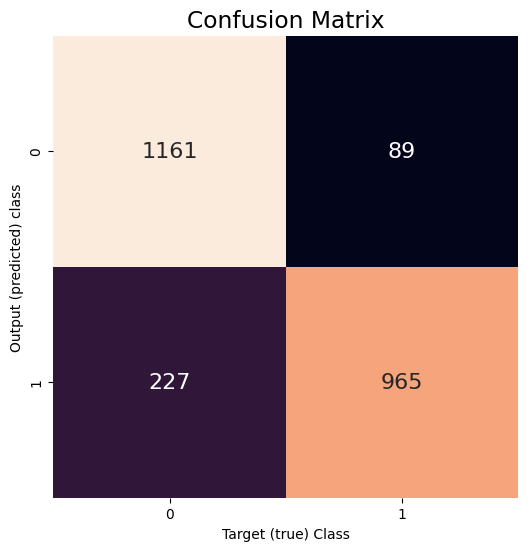

              precision    recall  f1-score   support

       licit       0.84      0.93      0.88      1250
     illicit       0.92      0.81      0.86      1192

    accuracy                           0.87      2442
   macro avg       0.88      0.87      0.87      2442
weighted avg       0.88      0.87      0.87      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): ClusterGCNConv(165, 128, diag_lambda=0.0)
    (1): ClusterGCNConv(128, 128, diag_lambda=0.0)
    (2): ClusterGCNConv(128, 1, diag_lambda=0.0)
  )
)


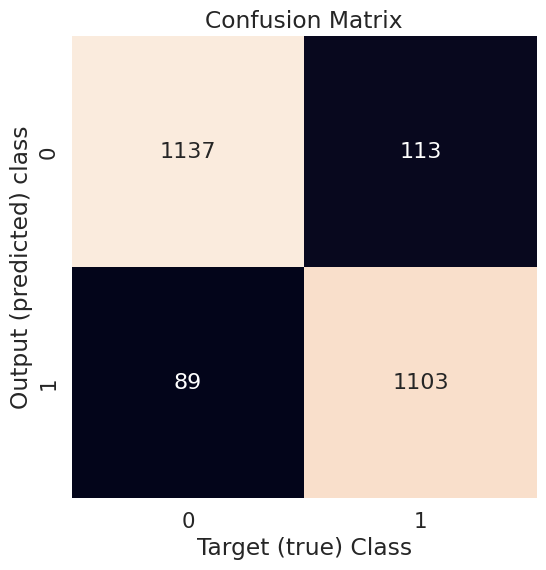

              precision    recall  f1-score   support

       licit       0.93      0.91      0.92      1250
     illicit       0.91      0.93      0.92      1192

    accuracy                           0.92      2442
   macro avg       0.92      0.92      0.92      2442
weighted avg       0.92      0.92      0.92      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): FeaStConv(165, 128, heads=1)
    (1): FeaStConv(128, 128, heads=1)
    (2): FeaStConv(128, 1, heads=1)
  )
)


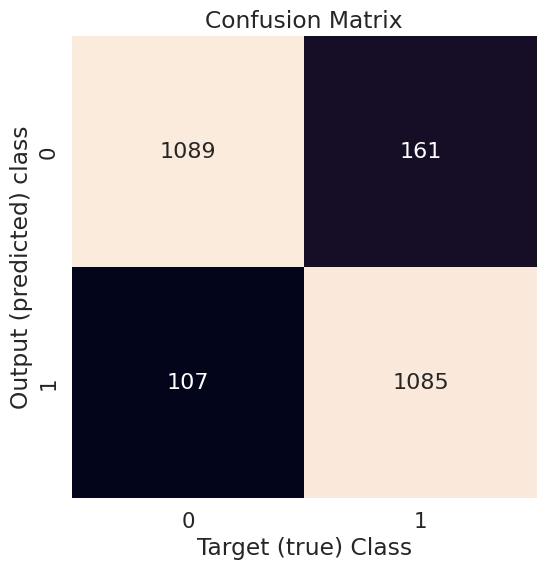

              precision    recall  f1-score   support

       licit       0.91      0.87      0.89      1250
     illicit       0.87      0.91      0.89      1192

    accuracy                           0.89      2442
   macro avg       0.89      0.89      0.89      2442
weighted avg       0.89      0.89      0.89      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): FiLMConv(165, 128, num_relations=1)
    (1): FiLMConv(128, 128, num_relations=1)
    (2): FiLMConv(128, 1, num_relations=1)
  )
)


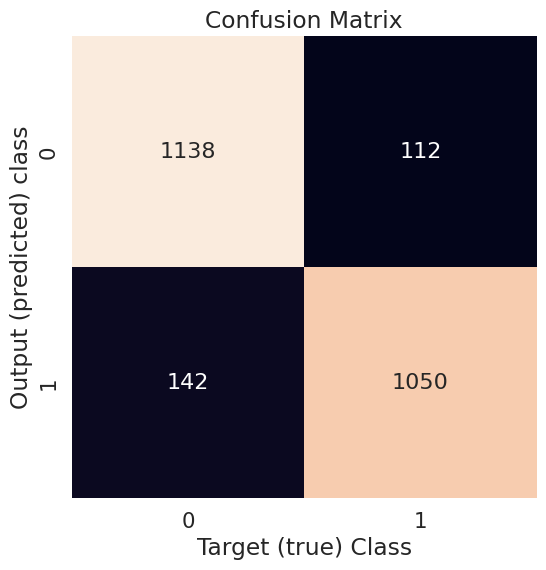

              precision    recall  f1-score   support

       licit       0.89      0.91      0.90      1250
     illicit       0.90      0.88      0.89      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GATConv(165, 128, heads=1)
    (1): GATConv(128, 128, heads=1)
    (2): GATConv(128, 1, heads=1)
  )
)


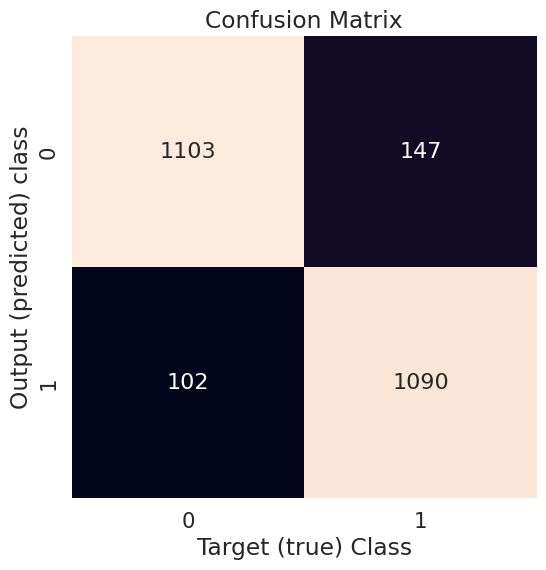

              precision    recall  f1-score   support

       licit       0.92      0.88      0.90      1250
     illicit       0.88      0.91      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GATv2Conv(165, 128, heads=1)
    (1): GATv2Conv(128, 128, heads=1)
    (2): GATv2Conv(128, 1, heads=1)
  )
)


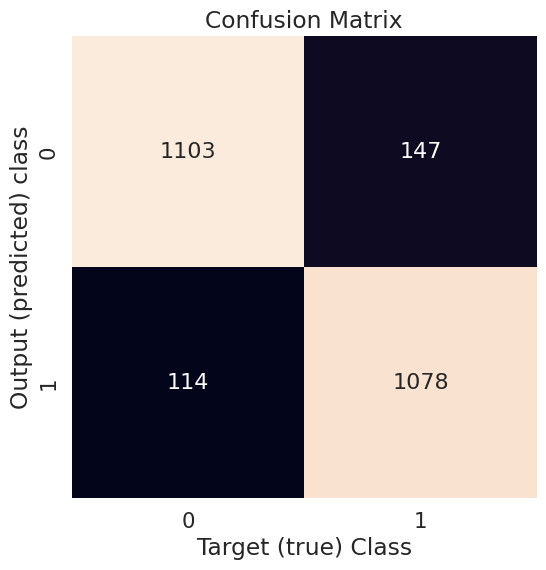

              precision    recall  f1-score   support

       licit       0.91      0.88      0.89      1250
     illicit       0.88      0.90      0.89      1192

    accuracy                           0.89      2442
   macro avg       0.89      0.89      0.89      2442
weighted avg       0.89      0.89      0.89      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GCNConv(165, 128)
    (1): GCNConv(128, 128)
    (2): GCNConv(128, 1)
  )
)


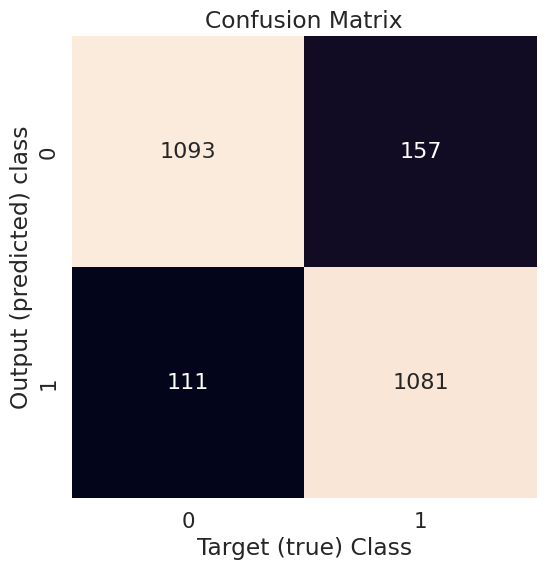

              precision    recall  f1-score   support

       licit       0.91      0.87      0.89      1250
     illicit       0.87      0.91      0.89      1192

    accuracy                           0.89      2442
   macro avg       0.89      0.89      0.89      2442
weighted avg       0.89      0.89      0.89      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GENConv(165, 128, aggr=softmax)
    (1): GENConv(128, 128, aggr=softmax)
    (2): GENConv(128, 1, aggr=softmax)
  )
)


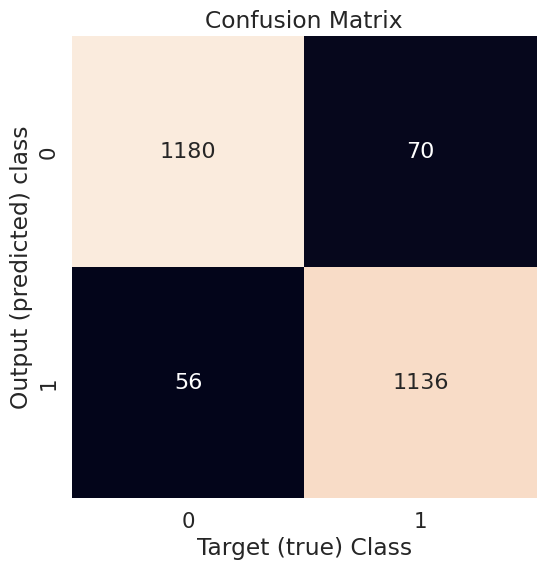

              precision    recall  f1-score   support

       licit       0.95      0.94      0.95      1250
     illicit       0.94      0.95      0.95      1192

    accuracy                           0.95      2442
   macro avg       0.95      0.95      0.95      2442
weighted avg       0.95      0.95      0.95      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GeneralConv(165, 128)
    (1): GeneralConv(128, 128)
    (2): GeneralConv(128, 1)
  )
)


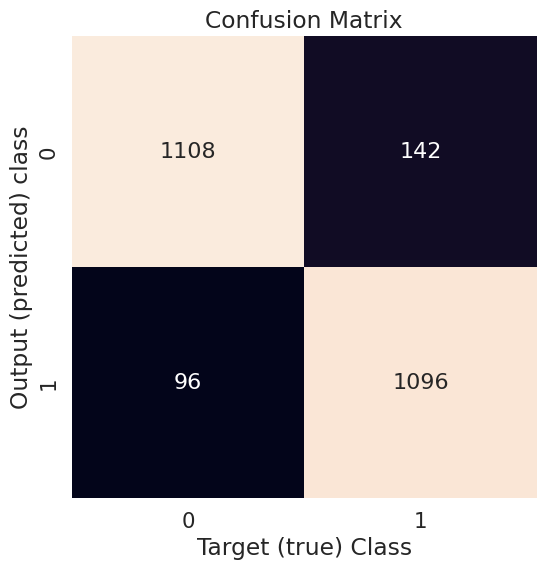

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): GraphConv(165, 128)
    (1): GraphConv(128, 128)
    (2): GraphConv(128, 1)
  )
)


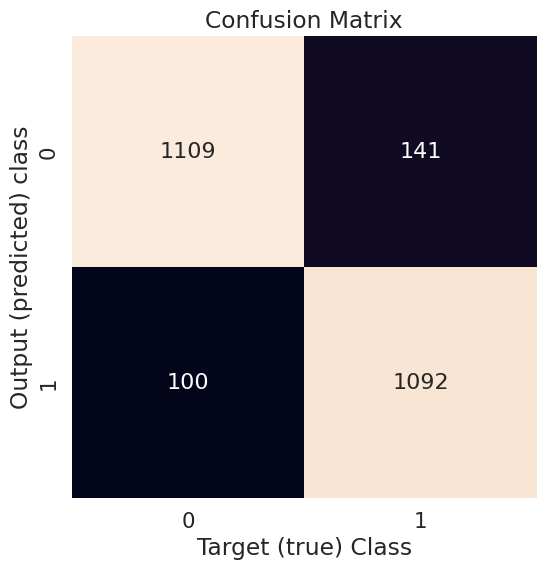

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): HypergraphConv(165, 128)
    (1): HypergraphConv(128, 128)
    (2): HypergraphConv(128, 1)
  )
)


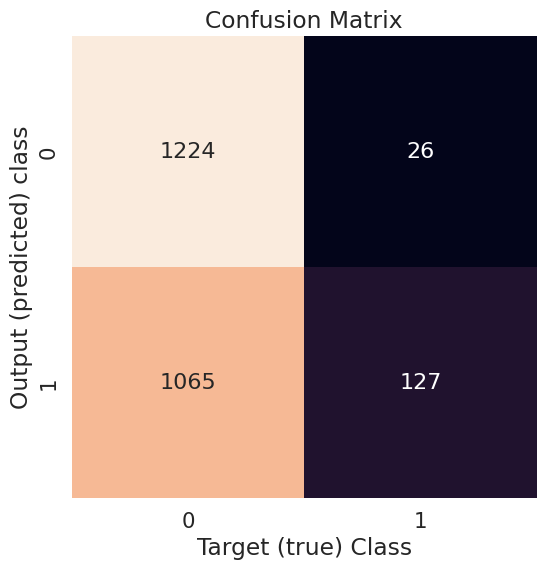

              precision    recall  f1-score   support

       licit       0.53      0.98      0.69      1250
     illicit       0.83      0.11      0.19      1192

    accuracy                           0.55      2442
   macro avg       0.68      0.54      0.44      2442
weighted avg       0.68      0.55      0.45      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): LEConv(165, 128)
    (1): LEConv(128, 128)
    (2): LEConv(128, 1)
  )
)


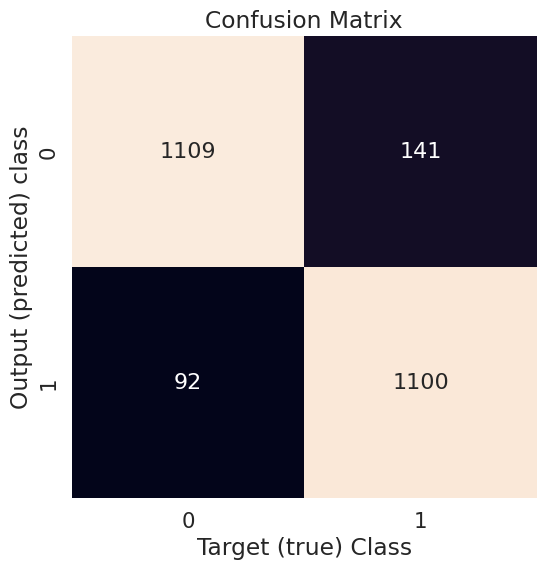

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.91      0.90      2442
weighted avg       0.91      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): MFConv(165, 128)
    (1): MFConv(128, 128)
    (2): MFConv(128, 1)
  )
)


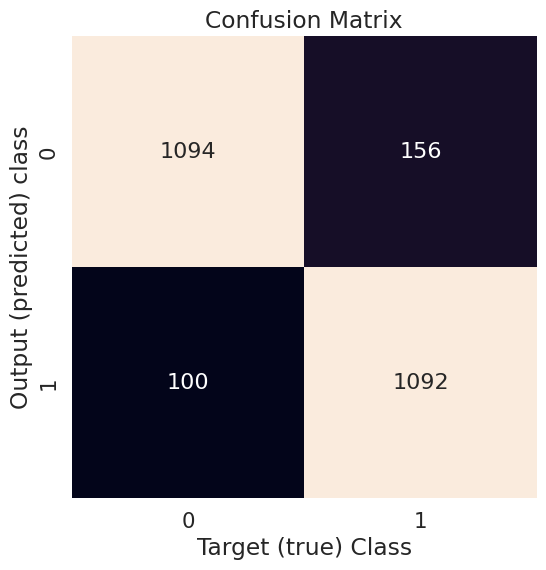

              precision    recall  f1-score   support

       licit       0.92      0.88      0.90      1250
     illicit       0.88      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): ResGatedGraphConv(165, 128)
    (1): ResGatedGraphConv(128, 128)
    (2): ResGatedGraphConv(128, 1)
  )
)


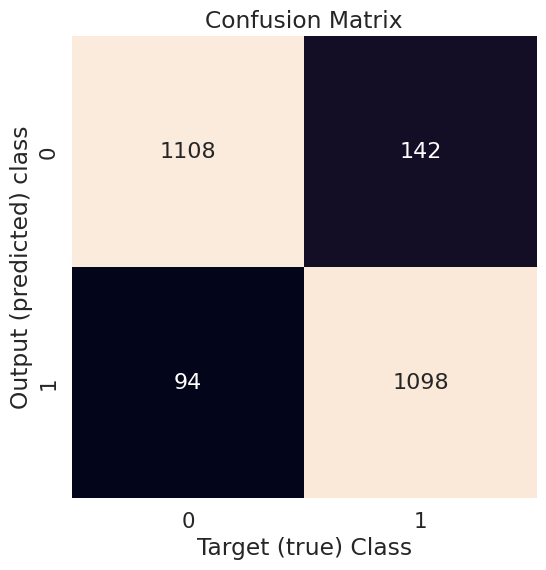

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): SAGEConv(165, 128, aggr=mean)
    (1): SAGEConv(128, 128, aggr=mean)
    (2): SAGEConv(128, 1, aggr=mean)
  )
)


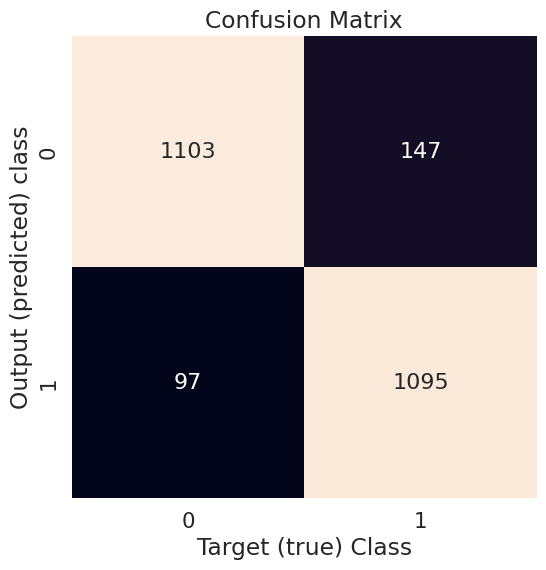

              precision    recall  f1-score   support

       licit       0.92      0.88      0.90      1250
     illicit       0.88      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): SGConv(165, 128, K=1)
    (1): SGConv(128, 128, K=1)
    (2): SGConv(128, 1, K=1)
  )
)


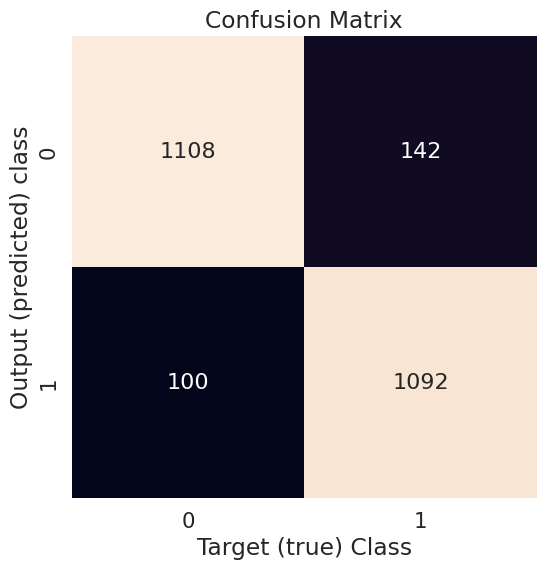

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.88      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): SuperGATConv(165, 128, heads=1, type=MX)
    (1): SuperGATConv(128, 128, heads=1, type=MX)
    (2): SuperGATConv(128, 1, heads=1, type=MX)
  )
)


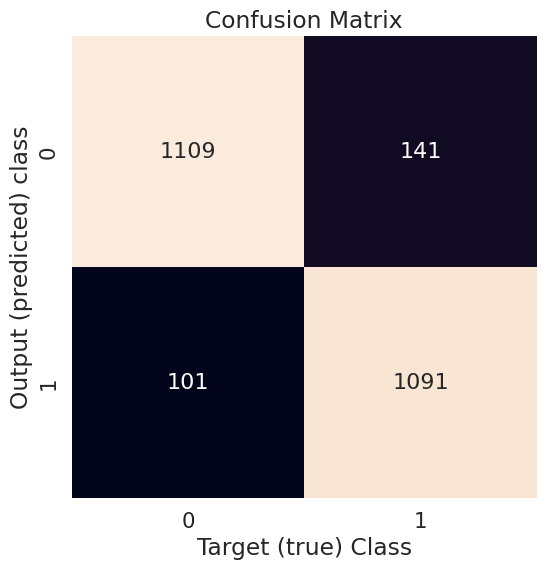

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): TAGConv(165, 128, K=3)
    (1): TAGConv(128, 128, K=3)
    (2): TAGConv(128, 1, K=3)
  )
)


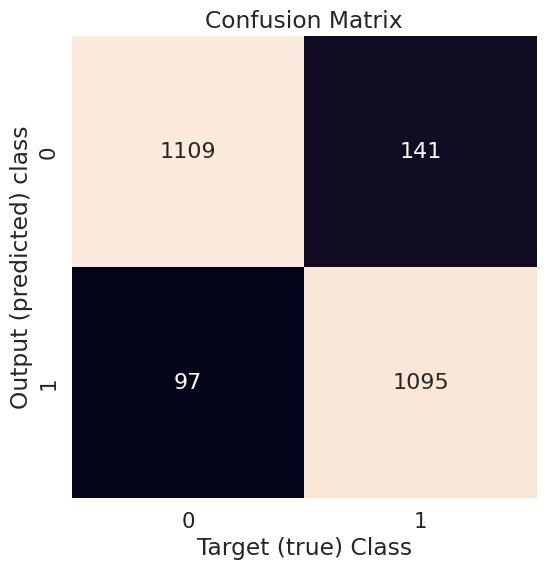

              precision    recall  f1-score   support

       licit       0.92      0.89      0.90      1250
     illicit       0.89      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

GNNGeneralModel(
  (layers): ModuleList(
    (0): TransformerConv(165, 128, heads=1)
    (1): TransformerConv(128, 128, heads=1)
    (2): TransformerConv(128, 1, heads=1)
  )
)


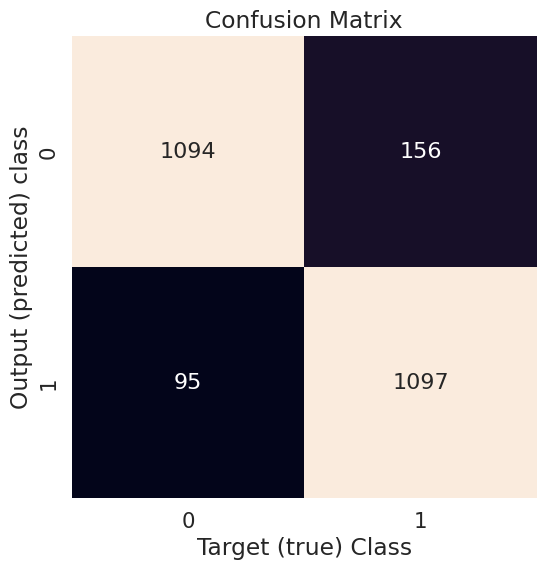

              precision    recall  f1-score   support

       licit       0.92      0.88      0.90      1250
     illicit       0.88      0.92      0.90      1192

    accuracy                           0.90      2442
   macro avg       0.90      0.90      0.90      2442
weighted avg       0.90      0.90      0.90      2442

Test data fraud cases, percentage: nan % 

Finalizado.



In [ ]:
# Bucle funcionando

import torch_geometric.nn.conv as conv
import inspect
#import pylibcugraphops

# Obtenemos todas las clases del módulo conv
conv_classes = inspect.getmembers(conv, inspect.isclass)


# Seleccionamos sólo las clases que heredan de torch.nn.Module y tienen un método forward
conv_layers = [layer[1] for layer in conv_classes if issubclass(layer[1], torch.nn.Module) and 
               hasattr(layer[1], 'forward') and 
               'in_channels' in inspect.signature(layer[1].__init__).parameters and
               'out_channels' in inspect.signature(layer[1].__init__).parameters]

conv_layers = [layer[1] for layer in conv_classes if issubclass(layer[1], torch.nn.Module) and 
               hasattr(layer[1], 'forward') ]

layers_not_used = []
reports = {}
fraud_pcnt = {} 
# Creamos un modelo con cada capa convolucional en la lista
for conv_layer in conv_layers:

    #params = inspect.signature(conv_layer.__init__).parameters
    #sig = inspect.signature(conv_layer.__init__)
    #required_params =  {name: param for name, param in sig.parameters.items() if param.default == inspect.Parameter.empty and name != "self" and name != "kwargs"}
    #required_params_set= [name for name in required_params.keys()]

    try:
      #model = torch.nn.Sequential(
      #    conv_layer(in_channels=16, out_channels=32),
      #    conv_layer(in_channels=32, out_channels=64),
      #    conv_layer(in_channels=64, out_channels=128)
      #).to(Config.device)
      
      model = GNNGeneralModel(Config.input_dim, Config.hidden_size, Config.output_dim, conv_layer, Config.num_layers).to(Config.device)
      #print(model.get_num_layers())
      #print(model)

      data_train = elliptic_dataset.to(Config.device)

      optimizer = torch.optim.Adam(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
      criterion = torch.nn.BCEWithLogitsLoss()
      train_evaluate(model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              type(conv_layer).__name__ + '.pth.tar')
      
      print(model)
      model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, type(conv_layer).__name__ + '.pth.tar'))['state_dict'])

      y_test_preds = test(model, data_train)

      # confusion matrix on validation data
      #aux_conf_mat = data_train.y[data_train.val_idx].detach().cpu()
      #conf_mat = confusion_matrix(aux_conf_mat.numpy(), y_test_preds[valid_idx])
      conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu().numpy())

      # impresión matriz de confusión
      plt.subplots(figsize=(6,6))
      sns.set(font_scale=1.4)
      sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
      plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
      plt.show();

      
      res = classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                                  y_test_preds[valid_idx].cpu().numpy(),
                                  target_names=['licit', 'illicit'])
      print (res)
      reports[conv_layer] = res

      print(f"Test data fraud cases, percentage: {round (y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100, 2)} % \n")
      fraud_pcnt[conv_layer] = round(y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100, 2)
      
      
    except Exception as e:
      #print(f"Error: {e}. Skipping item: {conv_layer}")
      layers_not_used.append(conv_layer)
      continue
      
print("Finalizado.\n")


    